# Low-complexity TCL controller

This notebook contains the code used to generate the figures in the associated paper (reference below) and a few additional figures for verification of the results. If you use this code or the associated library, please reference:

Simon Tindemans and Goran Strbac, "Low-complexity control algorithm for decentralised demand response using thermostatic loads", 2019 IEEE Conference on Environment and Electrical Engineering (EEEIC 2019), Genoa (Italy). doi: 10.1109/EEEIC.2019.8783359. arXiv:1904.12401

Author: Simon Tindemans, s.h.tindemans@tudelft.nl
Released under the MIT license.

In [1]:
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, njit, float64
import scipy.signal as signal
import time

Load TCL controller library

In [2]:
import TCLcontrol

Define plotting options

In [3]:
%matplotlib inline

mpl.rcParams['font.size']=7
mpl.rcParams['font.family']='Arial' #['sans-serif']  # might want to specify specific fonts, too, if default is not pretty.
#mpl.rcParams['pdf.fonttype']=42 # Use this to switch off font outlining, for later editing in illustrator, or MC submission
mpl.rcParams['axes.titlesize']='medium'
mpl.rcParams['legend.fontsize']='medium'
mpl.rcParams['axes.linewidth']=0.5
mpl.rcParams['lines.linewidth']=0.5
mpl.rcParams['patch.linewidth']=0.5
mpl.rcParams['lines.color']='k'
mpl.rcParams['figure.figsize']=[3.25,2.5]
mpl.rcParams['figure.dpi']=227/2   # only used for options in plt.clabel() and possibly pixel graphics
mpl.rcParams['savefig.dpi']=227/2  # effective browser resolution on 13 inch retina display

Create function to set random seed within numba-generated code, to aid reproducibility

In [4]:
@njit
def numba_random_seed(seed):
    np.random.seed(seed)

## Define models and control signal

basic model and randomised model generator

In [5]:
basic_model = TCLcontrol.Model(Toff=20, Ton=-44, Tmax=7, Tmin=2, alpha=(1.0/7200), width=0.9)

In [6]:
# ensure that the random factor is generated using the @njit decorator, so that the numba random seed is used for all calculations
@njit
def rfactor():
    return 0.8 + 0.4*np.random.random()

def random_model():
    return TCLcontrol.Model(Toff=20*rfactor(), Ton=-44*rfactor(), Tmax=7*rfactor(), Tmin=2*rfactor(), alpha=(1/7200)*rfactor(), width=0.9)

In [7]:
end_time = 3600
num_steps_small = 360
time_step = end_time / num_steps_small

current_time = 0
time_list_small = np.linspace(0, end_time, num_steps_small, False)

num_steps = 5*num_steps_small
time_list = np.linspace(0, 5*end_time, 5*num_steps_small, False)

In [8]:
# this implements the basic physics model
def update_temperature(initial_temperature, state, time_delta, model):
    return initial_temperature + time_delta*model.alpha*(model.Toff + state*(model.Ton - model.Toff) - initial_temperature)

Create reference power profile

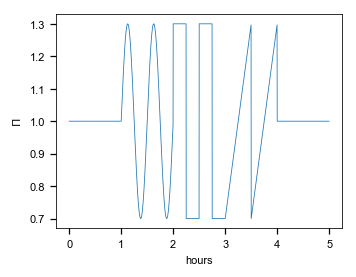

In [9]:
pi_profile1 = np.array([1.0 for time in time_list_small])
pi_profile2 = np.array([1.0 + 0.3 * np.sin(2*np.pi*time/1800) for time in time_list_small])
pi_profile3 = np.array([1.0 + 0.3 * signal.square(2*np.pi*time/1800) for time in time_list_small])
pi_profile4 = np.array([1.0 + 0.3 * signal.sawtooth(2*np.pi*time/1800) for time in time_list_small])

pi_profile = np.concatenate((pi_profile1, pi_profile2, pi_profile3, pi_profile4, pi_profile1))

plt.plot(time_list/3600, pi_profile)
plt.gca().set_xlabel('hours');
plt.gca().set_ylabel('$\Pi$');

## Single appliance

In [10]:
numba_random_seed(12345)

In [11]:
# define arrays for compressor state, temperature, rates and z-values
control_list = np.zeros(num_steps)
temperature_list = np.zeros(num_steps)
rate1_list = np.zeros(num_steps)
rate2_list = np.zeros(num_steps)
z_list = np.zeros(num_steps)

# initialise fridge at t=0 with random state and temperature
current_time = 0   
current_temperature, current_state = TCLcontrol.random_state(basic_model)

# simulate
for i in range(num_steps):
    # update control state
    current_state = TCLcontrol.update_state(
        requested_power=pi_profile[i], 
        current_temperature=current_temperature, 
        current_time=current_time, 
        model=basic_model, 
        previous_state=current_state
    )
    # update temperature 
    current_temperature = update_temperature(current_temperature, current_state.state, time_delta=time_step, model=basic_model)
    # forward time
    current_time += time_step
    
    # save state information
    control_list[i]=current_state.state
    temperature_list[i]=current_temperature
    rate1_list[i] = current_state.rate_off_on
    rate2_list[i] = current_state.rate_on_off
    z_list[i] = current_state.z
    


Plot of time-dependent stochastic switching rates

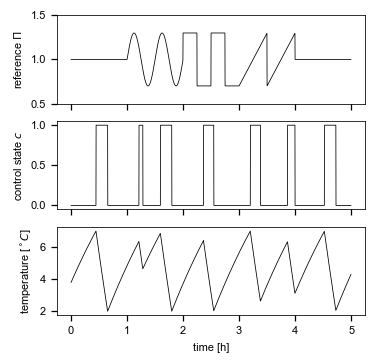

In [12]:
# Two subplots, the axes array is 1-d
fig, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(time_list/3600, pi_profile,'k')
axarr[1].plot(time_list/3600, control_list,'k')
axarr[2].plot(time_list/3600, temperature_list,'k')

fig.set_size_inches(3.5,3.5)
axarr[2].set_xlabel('time [h]')
axarr[0].set_ylabel('reference $\Pi$')
axarr[0].set_ylim((0.5,1.5))
axarr[1].set_ylabel('control state $c$')
axarr[2].set_ylabel('temperature [${}^\circ C$]')
fig.savefig('../results/single_appliance.pdf', bbox_inches="tight")

Plot of the off-on and on/off rates

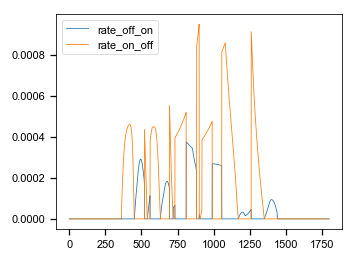

In [13]:
plt.plot(rate1_list, label='rate_off_on')
plt.plot(rate2_list, label='rate_on_off')
plt.legend()

Plot of the z-parameter (related to distribution-average temperature)

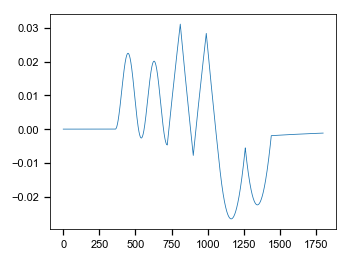

In [14]:
plt.plot(z_list)

## Array simulation

In [15]:

# JIT-compiled version of the physics model
@njit
def update_temperature(initial_temperature, state, time_delta, model, temp_offset=0):
    return initial_temperature + time_delta*model.alpha*(model.Toff + temp_offset + state*(model.Ton - model.Toff) - initial_temperature)


@njit
def run_fridge(pi_profile, control_model, physics_model = None):
    
    # optionally allow for the physics model (for temperature updates) to deviate from the control model
    if physics_model is None:
        physics_model = control_model
    
    # initialise random fridge state at t=0
    current_time = 0   
    current_temperature, current_state = TCLcontrol.random_state(control_model)
    
    num_steps = len(pi_profile)

    # initialise empty list for control states
    control_list = np.zeros(num_steps)

    for i in range(num_steps):
        current_state = TCLcontrol.update_state(
            requested_power=pi_profile[i], 
            current_temperature=current_temperature, 
            current_time=current_time, 
            model=control_model, 
            previous_state=current_state
        )
        current_temperature = update_temperature(current_temperature, current_state.state, time_delta=time_step, model=physics_model)
            
        current_time += time_step


        control_list[i]=current_state.state
                

    return control_list, physics_model.pi0

In [16]:
num_fridges = 1000
numba_random_seed(42)

results1k = np.zeros((num_fridges,num_steps))
dcycles1k = np.zeros(num_fridges)

for i in range(num_fridges):
    results1k[i], dcycles1k[i] = run_fridge(pi_profile, control_model=random_model(), physics_model=None)

In [17]:
num_fridges = 100000
numba_random_seed(12345)

results = np.zeros((num_fridges,num_steps))
dcycles = np.zeros(num_fridges)

start = time.time()
for i in range(num_fridges):
    results[i], dcycles[i] = run_fridge(pi_profile, control_model=random_model(), physics_model=None)
end = time.time()
print(end - start)

39.49020791053772


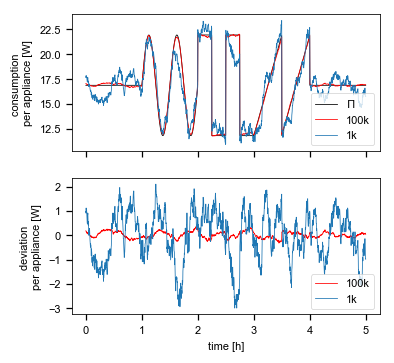

In [18]:
# Two subplots, the axes array is 1-d
fig, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(time_list/3600,70*dcycles.mean() * np.array(pi_profile),'k', label='$\Pi$')
axarr[0].plot(time_list/3600,70*results.mean(axis=0),'r',label='100k')
axarr[0].plot(time_list/3600,70*results1k.mean(axis=0), label='1k')
axarr[0].legend(loc='lower right')

axarr[1].plot(time_list/3600,70*(results.mean(axis=0)- dcycles.mean() * np.array(pi_profile)),'r',label='100k')
axarr[1].plot(time_list/3600,70*(results1k.mean(axis=0)- dcycles1k.mean() * np.array(pi_profile)),label='1k')
axarr[1].legend(loc='lower right')

#plt.axes().set_aspect(1)
fig.set_size_inches(3.5,3.5)
axarr[1].set_xlabel('time [h]')
axarr[0].set_ylabel('consumption \nper appliance [W]')
axarr[1].set_ylabel('deviation \nper appliance [W]')
fig.savefig('../results/multi_appliance.pdf', bbox_inches="tight")